## Loading

In [1]:
%load_ext autoreload
%autoreload 2

## Python version

In [2]:
import sys, site
print("Python:", sys.executable)
print("User site:", site.getusersitepackages())
print("Site-packages:", site.getsitepackages() if hasattr(site, "getsitepackages") else "n/a")

Python: /home/nicolas/.pyenv/versions/venv_python_3.11.5-GCCcore-13.2.0/bin/python
User site: /home/nicolas/.local/lib/python3.11/site-packages
Site-packages: ['/home/nicolas/.pyenv/versions/venv_python_3.11.5-GCCcore-13.2.0/lib/python3.11/site-packages']


## Librairies

In [3]:
import pickle
from tqdm import tqdm
from pathlib import Path

import numpy as np
import polars as pl
import pyarrow.parquet as pq

from matplotlib import pyplot as plt
from tqdm import tqdm

## Getting main file data

In [4]:
def getting_main_file_and_verification(
    df: pl.DataFrame,
    nt: int = 10000,
    tmax: int = 100,
    dt: int = 1,
    alphao: float = 0.0,
    alphaf: float = 1.0,
    beta: float = 0.0,
    Lmin: int = 0,
    Lmax: int = 50_000,
    origin: int = 10_000,
    bps: int = 1
) -> pl.DataFrame:
    """
    Filters a Polars DataFrame based on specific criteria.

    Args:
        df (pl.DataFrame): The input DataFrame containing the dataset.
        nt (int, default=1000): Number of time steps in the simulation.
        tmax (int, default=100000): Maximum simulation time.
        dt (int): Time step interval.
        alphao (float, default=0.5): Initial alpha value.
        alphaf (float, default=0.5): Final alpha value.
        beta (float, default=1.0): Beta value used in the simulation.
        Lmin (int, default=0): Minimum linker length.
        Lmax (int, default=500): Maximum linker length.
        origin (int, default=0): Origin value used in the setup.
        bps (int, default=10): Base pairs per step.

    Returns:
        pl.DataFrame: The filtered DataFrame based on the given parameters.
    """

    selected_columns = {
        "alpha_choice", "s", "l", "bpmin", 
        "mu", "theta", 
        "nt", "tmax", "dt", "times", 
        "alphao", "alphaf", "beta",
        "Lmin", "Lmax", "origin", "bps",
        
        "v_mean", "v_med", 
        "vf", "Cf", "wf", "vf_std", "Cf_std", "wf_std", 
        "vi_mean", "vi_med", "vi_mp",
    }

    # Select only the required columns
    filtered_columns = [col for col in df.columns if col in selected_columns]
    filtered_df = df.select(filtered_columns)

    # Verify that all rows have 's' equal to 150
    if (filtered_df["s"] == 150).all():
        print("All rows have s = 150.")
    else:
        print("Some rows do not have s = 150.")
        print(filtered_df.filter(pl.col("s") != 150))

    # Apply filtering based on predefined conditions
    filtered_df = (
        filtered_df
        .filter(pl.col("nt") == nt)
        .filter(pl.col("tmax") == tmax)
        .filter(pl.col("dt") == dt)
        .filter(pl.col("alphao") == alphao)
        .filter(pl.col("alphaf") == alphaf)
        .filter(pl.col("beta") == beta)
        .filter(pl.col("Lmin") == Lmin)
        .filter(pl.col("Lmax") == Lmax)
        .filter(pl.col("origin") == origin)
        .filter(pl.col("bps") == bps)
    )

    return filtered_df


# Reading it for further manipulations
main_file_path = Path.home() / "Documents" / "PhD" / "Workspace" / "nucleo" / "outputs" / "2025-01-01_PSMN" / "ncl_output.parquet"
data = pq.read_table(main_file_path)
df_polars = pl.DataFrame(data)

# Loading file + Filtering
df_pl_main = getting_main_file_and_verification(df_polars)
print('The df_polars containing the int and floats for all our simulations :\nTotal shape :',df_pl_main.shape, '\nQuick print and shape :', df_pl_main.head(5))

All rows have s = 150.
The df_polars containing the int and floats for all our simulations :
Total shape : (131300, 27) 
Quick print and shape : shape: (5, 27)
┌──────────────┬─────┬─────┬───────┬───┬────────┬───────────┬────────────┬───────┐
│ alpha_choice ┆ s   ┆ l   ┆ bpmin ┆ … ┆ wf_std ┆ vi_mean   ┆ vi_med     ┆ vi_mp │
│ ---          ┆ --- ┆ --- ┆ ---   ┆   ┆ ---    ┆ ---       ┆ ---        ┆ ---   │
│ str          ┆ i64 ┆ i64 ┆ i64   ┆   ┆ f64    ┆ f64       ┆ f64        ┆ f64   │
╞══════════════╪═════╪═════╪═══════╪═══╪════════╪═══════════╪════════════╪═══════╡
│ nt_random    ┆ 150 ┆ 10  ┆ 15    ┆ … ┆ 0.004  ┆ 42.932289 ┆ 0.000023   ┆ 0.5   │
│ nt_random    ┆ 150 ┆ 10  ┆ 15    ┆ … ┆ 0.005  ┆ 53.026867 ┆ 0.009536   ┆ 0.5   │
│ nt_random    ┆ 150 ┆ 10  ┆ 15    ┆ … ┆ 0.007  ┆ 53.843803 ┆ 0.001263   ┆ 0.5   │
│ nt_random    ┆ 150 ┆ 10  ┆ 15    ┆ … ┆ 0.007  ┆ 31.117475 ┆ 0.000045   ┆ 0.5   │
│ nt_random    ┆ 150 ┆ 10  ┆ 15    ┆ … ┆ 0.005  ┆ 23.223647 ┆ 3.2930e-15 ┆ 0.5   │
└─────────

## Heatmaps

Plotting heatmaps: 100%|██████████| 13/13 [00:00<00:00, 22.23it/s]


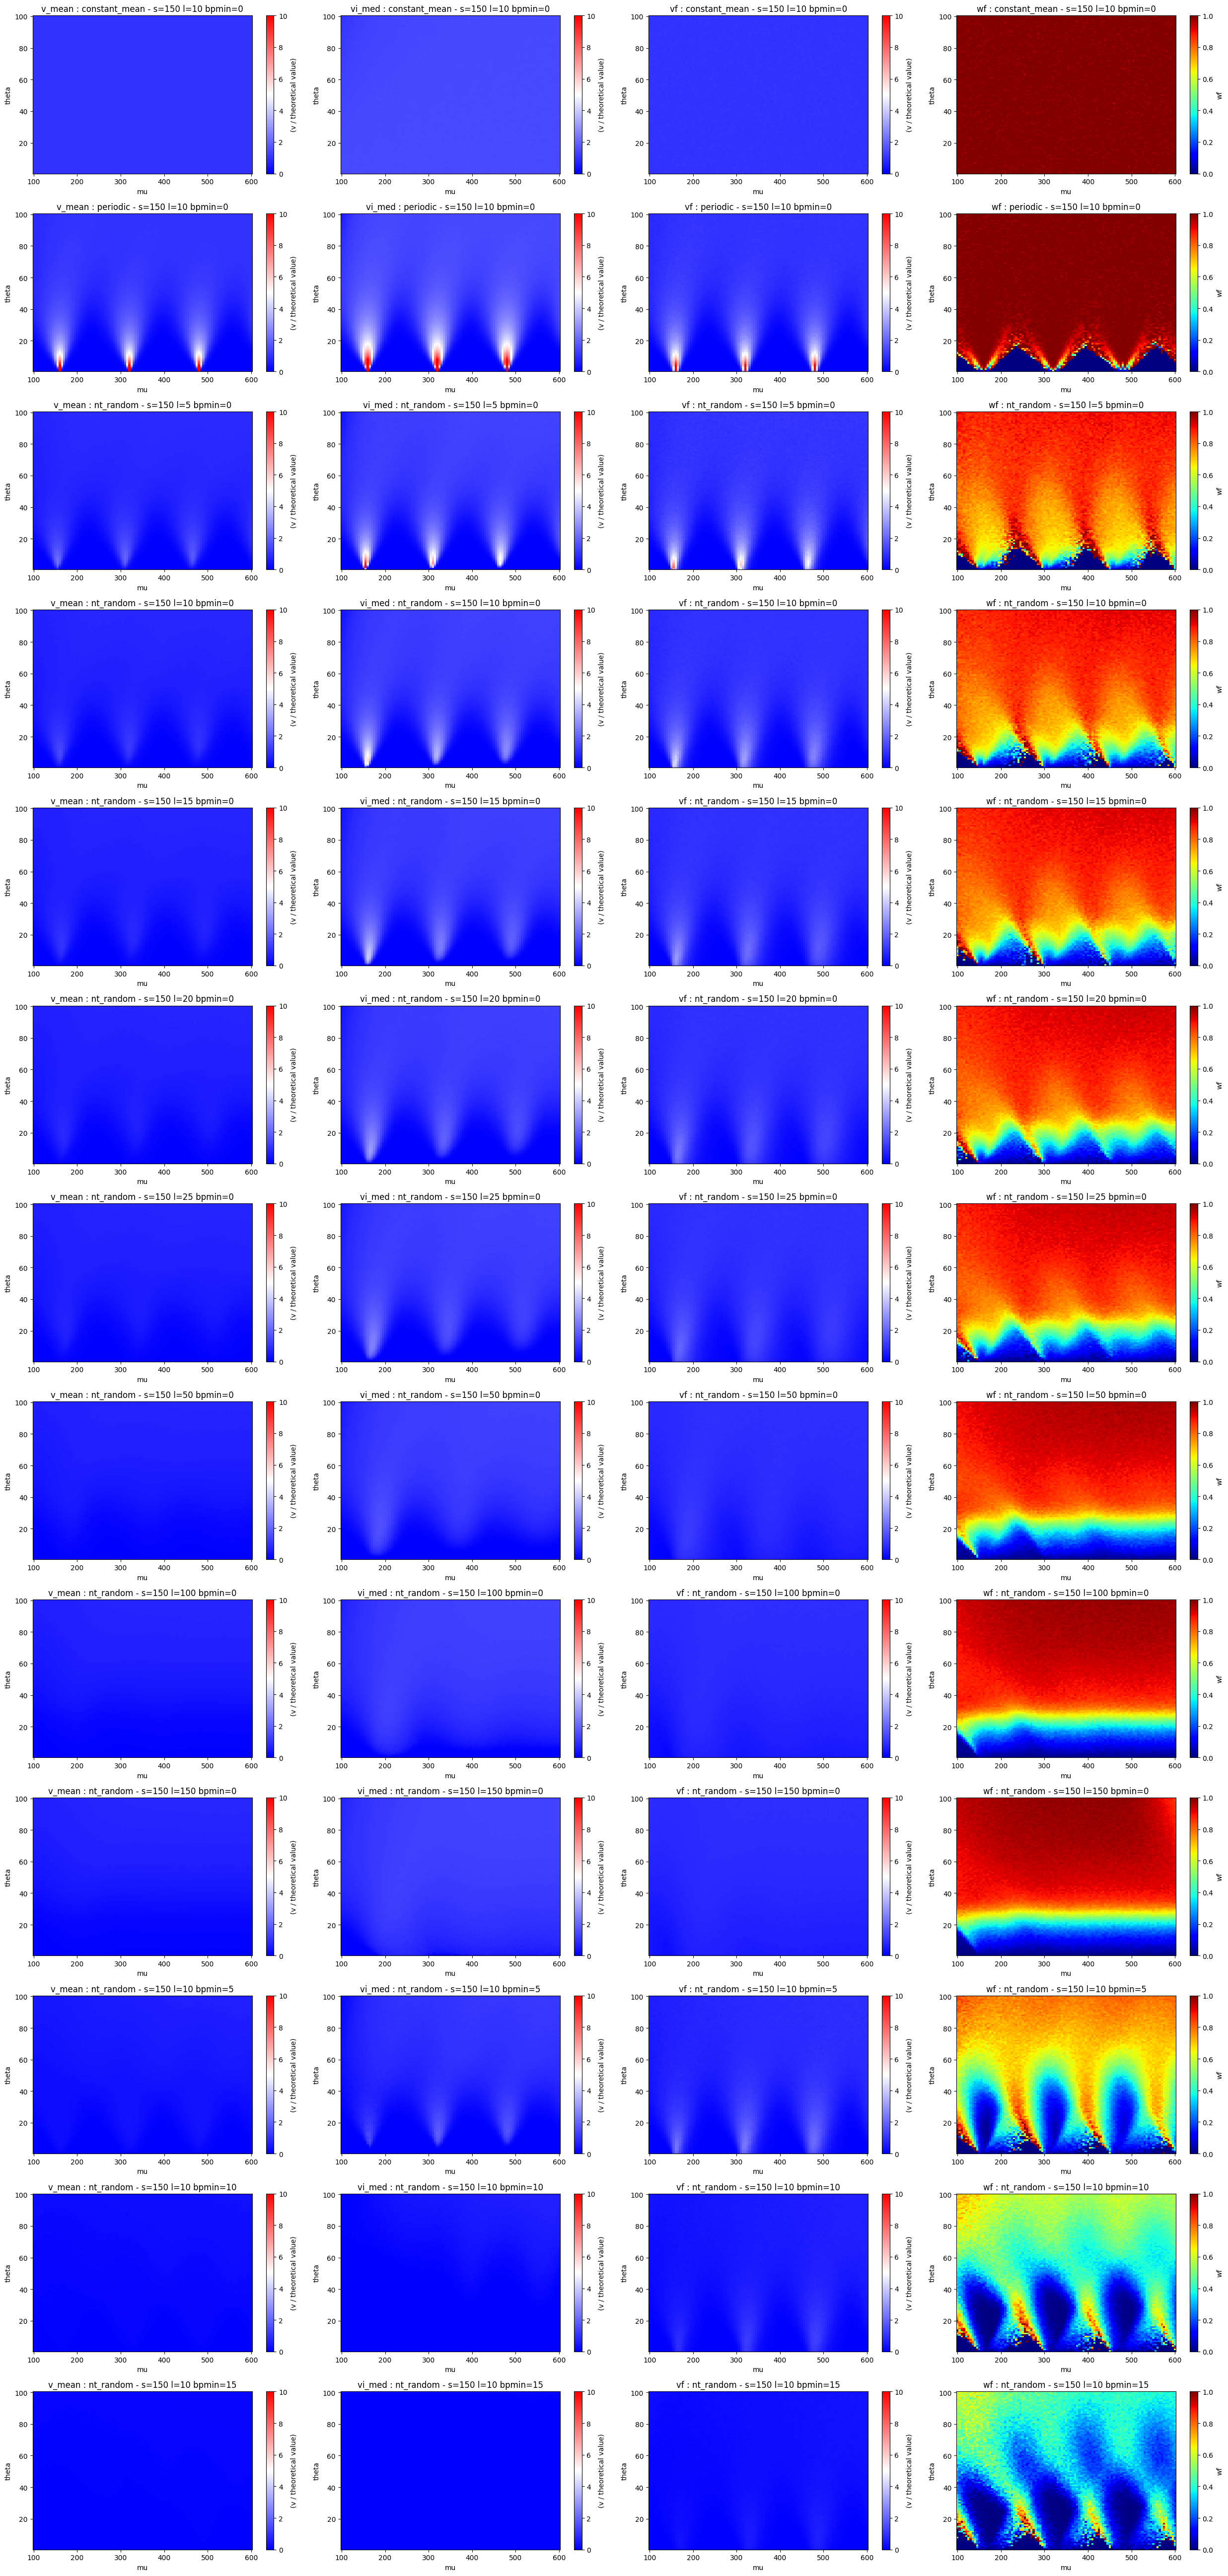

In [5]:
def ncl_plot_precomputed_heatmaps(speed_cols, root = Path.home() / "Documents" / "PhD" / "Workspace" / "nucleo" / "outputs" / "2025-01-01_PSMN", type_of_data="raw", plot_log2=False):
    """
    Plots heatmaps of either raw or log2-transformed values depending on the variable:
    - log2 + bwr for all except wf
    - linear + jet for wf

    Data are already normalized by the theoretical values of the constant_value scenario !

    """

    if plot_log2:
        title_bar_mini = "log₂ "
    else:
        title_bar_mini = ""

    if type_of_data not in ["raw", "norm_mu", "norm_th"]:
        raise ValueError ("No such type_of_data possible to plot.")

    if type_of_data == "raw":
        main_file_path = root / "hmp_nucleo_raw.pkl"
        title_bar = title_bar_mini + "v"
        if plot_log2:
            vmin, vmax = -2, 10
        else :
            vmin, vmax = 0, 50

    elif type_of_data == "norm_mu":
        main_file_path = root / "hmp_nucleo_nmu.pkl"
        title_bar = title_bar_mini + "(v / mean value)"
        if plot_log2:
            vmin, vmax = -1, 0.010
        else:
            vmin, vmax = 0, 0.50

    elif type_of_data == "norm_th":
        main_file_path = root / "hmp_nucleo_nth.pkl"
        title_bar = title_bar_mini + "(v / theoretical value)"
        if plot_log2:
            vmin, vmax = -2, 2
        else:
            vmin, vmax = 0, 10

    with open(main_file_path, "rb") as f:
        computed_data = pickle.load(f)

    n_combinations = len(computed_data)
    fig, axes = plt.subplots(nrows=n_combinations, ncols=len(speed_cols), figsize=(25, 4 * n_combinations))
    axes = np.atleast_2d(axes)

    for idx, (key, config_data) in enumerate(tqdm(computed_data.items(), total=n_combinations, desc="Plotting heatmaps")):
        mu_values = config_data["mu_values"]
        theta_values = config_data["theta_values"]
        config = config_data["config"]

        for col_idx, speed_col in enumerate(speed_cols):
            ax = axes[idx, col_idx]
            data = config_data[speed_col]

            if speed_col == "wf":
                cmap = 'jet'
                wmin = 0
                wmax = 1
                data_to_plot = data
                c = ax.pcolormesh(mu_values, theta_values, data_to_plot, cmap=cmap, vmin=wmin, vmax=wmax)
                cbar = plt.colorbar(c, ax=ax)
                cbar.set_label(f"{speed_col}")

            else:
                cmap = 'bwr'
                if plot_log2: 
                    data_to_fix = np.log2(data, dtype=float)
                    data_to_plot = np.nan_to_num(data_to_fix, nan=0.0)
                else:
                    data_to_plot = data
                c = ax.pcolormesh(mu_values, theta_values, data_to_plot, cmap=cmap, vmin=vmin, vmax=vmax)
                cbar = plt.colorbar(c, ax=ax)
                cbar.set_label(title_bar)

            ax.set_title(f"{speed_col} : {config['alpha_choice']} - s={config['s']} l={config['l']} bpmin={config['bpmin']}")
            ax.set_xlabel("mu")
            ax.set_ylabel("theta")

    plt.tight_layout()
    plt.show()


# --- Load Data and Plot --- #
ncl_plot_precomputed_heatmaps(
    # speed_cols=["v_mean", "vi_med", "vi_mp", "vf", "wf"]
    speed_cols=["v_mean", "vi_med", "vf", "wf"],
    type_of_data = "norm_th",
    plot_log2=False
)

## Cross-sections

Courbe de valeur maximale de (vi_med / mu) en fonction du point le plus chaud en suivant les configs en fait

Donc c'est extraire le point maximal pour chaque config 

Puis tracer ce point maximal en fonction de la config et donc de la taille du linker

In [10]:
root_scenario = Path.home() / "Documents" / "PhD" / "Workspace" / "nucleo" / "outputs" / "2025-01-01_PSMN" / "scenarios.json"
scenarios = pl.read_json(root_scenario)
print(scenarios)

shape: (13, 4)
┌─────┬─────┬───────┬───────────────┐
│ s   ┆ l   ┆ bpmin ┆ alpha_choice  │
│ --- ┆ --- ┆ ---   ┆ ---           │
│ i64 ┆ i64 ┆ i64   ┆ str           │
╞═════╪═════╪═══════╪═══════════════╡
│ 150 ┆ 10  ┆ 0     ┆ constant_mean │
│ 150 ┆ 10  ┆ 0     ┆ periodic      │
│ 150 ┆ 5   ┆ 0     ┆ nt_random     │
│ 150 ┆ 10  ┆ 0     ┆ nt_random     │
│ 150 ┆ 15  ┆ 0     ┆ nt_random     │
│ …   ┆ …   ┆ …     ┆ …             │
│ 150 ┆ 100 ┆ 0     ┆ nt_random     │
│ 150 ┆ 150 ┆ 0     ┆ nt_random     │
│ 150 ┆ 10  ┆ 5     ┆ nt_random     │
│ 150 ┆ 10  ┆ 10    ┆ nt_random     │
│ 150 ┆ 10  ┆ 15    ┆ nt_random     │
└─────┴─────┴───────┴───────────────┘


In [65]:
work_df = df_pl_main
work_s = 150
work_l = 10
work_bpmin = 0
work_alphachoice = "nt_random"

work_proba_name = "theta"
work_proba_value = 50

work_value = "vi_med"

In [93]:
import polars as pl

def cut_single_proba(
    df: pl.DataFrame,
    s: int,
    l: int,
    bpmin: int,
    alpha_choice: str,
    proba_name: str,
    proba_value: int
) -> pl.DataFrame:
    """
    Filter a Polars DataFrame to extract a subset of simulations
    for a specific configuration and probability parameter.

    Parameters
    ----------
    df : pl.DataFrame
        The input Polars DataFrame containing simulation results.
    s : int
        Value of the `s` parameter to filter on.
    l : int
        Value of the `l` parameter to filter on.
    bpmin : int
        Value of the `bpmin` parameter to filter on.
    alpha_choice : str
        Value of the `alpha_choice` parameter to filter on.
    proba_value : int or float
        Value of the probability parameter (`mu` or `theta`) to filter on.
    proba_name : str, default="mu"
        Which probability parameter to filter on. Must be `"mu"` or `"theta"`.

    Returns
    -------
    pl.DataFrame
        A filtered Polars DataFrame containing only rows matching
        the provided configuration and probability parameter.
    """

    # Mask for simulation configuration
    mask_config = (
        (df["s"] == s)
        & (df["l"] == l)
        & (df["bpmin"] == bpmin)
        & (df["alpha_choice"] == alpha_choice)
    )

    # Mask for probability parameter
    if proba_name == "mu":
        mask_probas = df["mu"] == proba_value
    elif proba_name == "theta":
        mask_probas = df["theta"] == proba_value
    else:
        raise ValueError(f"Invalid proba_name '{proba_name}'. Must be 'mu' or 'theta'.")

    # Combine and filter
    return df.filter(mask_config & mask_probas)

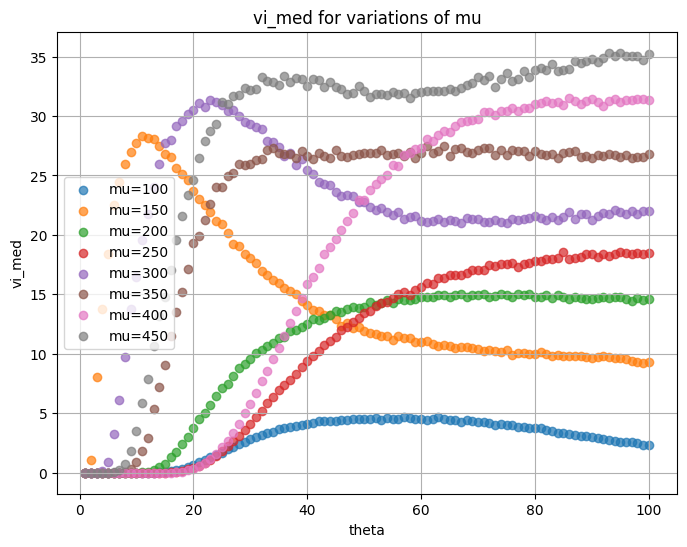

In [104]:
# ------------------- Config ------------------- #
work_proba_choice = "mu"    # celui qu’on fait varier
work_speed = "vi_med"

work_proba_names = ["mu", "theta"]
if work_proba_choice == "mu":
    work_proba_values = np.arange(50, 500, 50)
elif work_proba_choice == "theta":
    work_proba_values = np.arange(10, 100, 10)
other = {"mu": "theta", "theta": "mu"}[work_proba_choice]  # l’autre variable

# ------------------- Plot ------------------- #
plt.figure(figsize=(8, 6))

for val in work_proba_values:
    df_sel = cut_single_proba(
        work_df,
        s=work_s,
        l=work_l,
        bpmin=work_bpmin,
        alpha_choice=work_alphachoice,
        proba_value=val,
        proba_name=work_proba_choice,
    )

    if df_sel.is_empty():
        continue  # saute les cas vides

    plt.scatter(
        df_sel[other],
        df_sel[work_speed],
        alpha=0.7,
        marker="o",
        label=f"{work_proba_choice}={val}",
    )

plt.title(f"{work_speed} for variations of {work_proba_name}")
plt.xlabel(other)
plt.ylabel(work_speed)
plt.grid(True, which="both")
plt.legend()
plt.show()

Working on: shape: (1, 4)
┌─────┬─────┬───────┬──────────────┐
│ s   ┆ l   ┆ bpmin ┆ alpha_choice │
│ --- ┆ --- ┆ ---   ┆ ---          │
│ i64 ┆ i64 ┆ i64   ┆ str          │
╞═════╪═════╪═══════╪══════════════╡
│ 150 ┆ 10  ┆ 0     ┆ nt_random    │
└─────┴─────┴───────┴──────────────┘ 
With: output=vi_med - fx_name=theta - fx_value=50
shape: (1, 27)
┌──────────────┬─────┬─────┬───────┬───┬────────┬─────────────┬───────────┬───────┐
│ alpha_choice ┆ s   ┆ l   ┆ bpmin ┆ … ┆ wf_std ┆ vi_mean     ┆ vi_med    ┆ vi_mp │
│ ---          ┆ --- ┆ --- ┆ ---   ┆   ┆ ---    ┆ ---         ┆ ---       ┆ ---   │
│ str          ┆ i64 ┆ i64 ┆ i64   ┆   ┆ f64    ┆ f64         ┆ f64       ┆ f64   │
╞══════════════╪═════╪═════╪═══════╪═══╪════════╪═════════════╪═══════════╪═══════╡
│ nt_random    ┆ 150 ┆ 10  ┆ 0     ┆ … ┆ 0.002  ┆ 1381.012645 ┆ 55.924852 ┆ 0.5   │
└──────────────┴─────┴─────┴───────┴───┴────────┴─────────────┴───────────┴───────┘


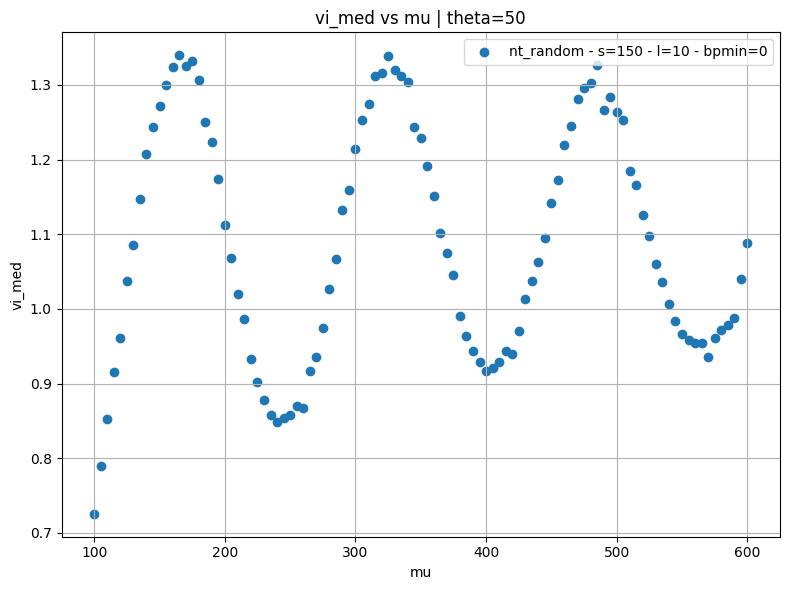

In [117]:
def ncl_cut_1D(df: pl.DataFrame, config: dict, output: str, fx_name: str, fx_value: float, norm_type=None, plot_log2=False) -> tuple[list, list]:
    
    # Proper call of function
    if output not in ["v_mean", "vi_med", "vi_mp", "vf", "wf"]:
        raise ValueError(f"Invalid speed_col: '{output}'")
    if fx_name not in ["mu", "theta"]:
        raise ValueError(f"Invalid fixed_input: '{fx_name}'")
    if norm_type not in ["raw", "norm_mu", "norm_th"]:
        raise ValueError(f"Invalid norm_type: '{norm_type}'")

    # Filtering data corresponding to configuration
    filters = (
        (pl.col("s") == config["s"]) &
        (pl.col("l") == config["l"]) &
        (pl.col("bpmin") == config["bpmin"]) &
        (pl.col("alpha_choice") == config["alpha_choice"])
    )

    # Fixed and non-fixed parameters
    if fx_name == "theta":
        mv_name = "mu"
    else: 
        mv_name = "theta"

    # Getting datas
    df_filtered = df.filter(filters & (pl.col(fx_name) == fx_value))
    x_values = df_filtered[mv_name].to_numpy()
    y_values = df_filtered[output].to_numpy()
    mu_values = df_filtered["mu"].to_numpy()

    # Test
    mu_min = 100
    mu_max = 250
    df_test = df.filter(filters & (pl.col("mu") > mu_min) & (pl.col("mu") < mu_max))
    row_vi_med_max = df_test.filter(pl.col("vi_med") == pl.max("vi_med")) # Max de vi_med pas de vi_med sur mu
    idx_max = row_vi_med_max["mu"].to_numpy()
    print(row_vi_med_max)
    
    # Du coup, le fix parameters ou du moins sa valeur est issue de idx_max : on selectionne la colonne de la heatmap mu = 160
    # On extraie les valeurs telles que mu = 160 pour tous les theta
    # Et ensuite, on conserve ce max, que l'on plot pour chaque configuration aléatoire de (s,l) et on  a notre graph pour observer si rescue ou pas

    # Normalizations
    if norm_type:
        if norm_type == "norm_mu":
            norm = mu_values
        if norm_type == "norm_th":
            alpha_o = df_filtered['alphao'][0]
            alpha_f = df_filtered['alphaf'][0]
            s = df_filtered['s'][0]
            l = df_filtered['l'][0]
            norm = (alpha_o * s + alpha_f * l) / (s + l) * mu_values

    # Normalizing or not
    if output in {'v_mean', 'vi_med', 'vi_mp', 'vf'}:
        y_values = np.array(y_values) / norm
    elif output in {'Cf', 'wf'}:
        pass

    # Getting datas in log2 or not
    if plot_log2:
        y_values = np.log2(np.clip(y_values, 1e-10, None))
    else : 
        y_values = np.array(y_values)

    # Done
    return x_values, y_values


def short_cfg_line(cfg):
    get = lambda k: (cfg[k].item() if hasattr(cfg[k], "item") else cfg[k])
    return f"{get('alpha_choice')} - s={get('s')} - l={get('l')} - bpmin={get('bpmin')}"


# Parameters
cfg = scenarios[3]
output = "vi_med"
fx_name = "theta"
fx_value = 50
print(f"Working on: {cfg} \nWith: output={output} - fx_name={fx_name} - fx_value={fx_value}")


# Call
x_plot, y_plot = ncl_cut_1D(
    df=work_df,
    config=cfg,
    output=output,
    fx_name=fx_name,
    fx_value=fx_value,
    norm_type="norm_th",
    plot_log2=False,
)


# Plot
plt.figure(figsize=(8, 6))
short_cfg = short_cfg_line(cfg)
mv_name = "mu" if fx_name == "theta" else "theta"
plt.title(f"{output} vs {mv_name} | {fx_name}={fx_value}")
plt.scatter(x_plot, y_plot, marker="o", label=f"{short_cfg}")
plt.xlabel(mv_name)
plt.ylabel(output + (" (log2)" if False else ""))
plt.grid(True, which="both")
plt.legend()
plt.tight_layout()
plt.show()

Attention perte de periodicité au fur et à mesure

Necessite une detection automatique du point le plus chaud : récupérer son mu_value

shape: (1, 27)
┌──────────────┬─────┬─────┬───────┬───┬────────┬────────────┬───────────┬───────┐
│ alpha_choice ┆ s   ┆ l   ┆ bpmin ┆ … ┆ wf_std ┆ vi_mean    ┆ vi_med    ┆ vi_mp │
│ ---          ┆ --- ┆ --- ┆ ---   ┆   ┆ ---    ┆ ---        ┆ ---       ┆ ---   │
│ str          ┆ i64 ┆ i64 ┆ i64   ┆   ┆ f64    ┆ f64        ┆ f64       ┆ f64   │
╞══════════════╪═════╪═════╪═══════╪═══╪════════╪════════════╪═══════════╪═══════╡
│ nt_random    ┆ 150 ┆ 5   ┆ 0     ┆ … ┆ 0.001  ┆ 630.167885 ┆ 52.527642 ┆ 0.5   │
└──────────────┴─────┴─────┴───────┴───┴────────┴────────────┴───────────┴───────┘
shape: (1, 27)
┌──────────────┬─────┬─────┬───────┬───┬────────┬─────────────┬───────────┬───────┐
│ alpha_choice ┆ s   ┆ l   ┆ bpmin ┆ … ┆ wf_std ┆ vi_mean     ┆ vi_med    ┆ vi_mp │
│ ---          ┆ --- ┆ --- ┆ ---   ┆   ┆ ---    ┆ ---         ┆ ---       ┆ ---   │
│ str          ┆ i64 ┆ i64 ┆ i64   ┆   ┆ f64    ┆ f64         ┆ f64       ┆ f64   │
╞══════════════╪═════╪═════╪═══════╪═══╪════════╪════

NameError: name 'short_cfg_3' is not defined

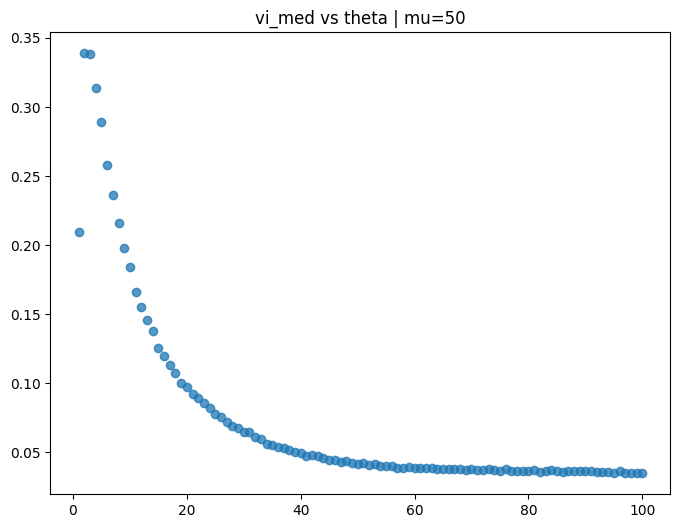

In [122]:

output = "vi_med"
fx_name = "mu"
norm_type = "norm_mu"

cfg_2 = scenarios[2]
short_cfg_2 = short_cfg_line(cfg)
mv_name = "mu" if fx_name == "theta" else "theta"
s2, l2 = 150, 5
fx_value_2 = s2 + l2
x_plot_2, y_plot_2 = ncl_cut_1D(df=work_df, config=cfg_2, output=output, fx_name=fx_name, fx_value=fx_value_2, norm_type=norm_type, plot_log2=False)

cfg_3 = scenarios[3]
s3, l3 = 150, 10
fx_value_3 = s3 + l3
x_plot_3, y_plot_3 = ncl_cut_1D(df=work_df, config=cfg_3, output=output, fx_name=fx_name, fx_value=fx_value_3, norm_type=norm_type, plot_log2=False)

cfg_4 = scenarios[4]
s4, l4 = 150, 15
fx_value_4 = s4 + l4
x_plot_4, y_plot_4 = ncl_cut_1D(df=work_df, config=cfg_4, output=output, fx_name=fx_name, fx_value=fx_value_4, norm_type=norm_type, plot_log2=False)

cfg_5 = scenarios[5]
s5, l5 = 150, 20
fx_value_5 = s5 + l5
x_plot_5, y_plot_5 = ncl_cut_1D(df=work_df, config=cfg_5, output=output, fx_name=fx_name, fx_value=fx_value_5, norm_type=norm_type, plot_log2=False)

cfg_6 = scenarios[6]
s6, l6 = 150, 25
fx_value_6 = s6 + l6
x_plot_6, y_plot_6 = ncl_cut_1D(df=work_df, config=cfg_6, output=output, fx_name=fx_name, fx_value=fx_value_6, norm_type=norm_type, plot_log2=False)

plt.figure(figsize=(8,6))
plt.title(f"{output} vs {mv_name} | {fx_name}={fx_value}")
plt.scatter(x_plot_2, y_plot_2, marker="o", label=f"{short_cfg_2}", alpha=0.75)
plt.scatter(x_plot_3, y_plot_3, marker="o", label=f"{short_cfg_3}", alpha=0.75)
plt.scatter(x_plot_4, y_plot_4, marker="o", label=f"{short_cfg_4}", alpha=0.75)
plt.scatter(x_plot_5, y_plot_5, marker="o", label=f"{short_cfg_5}", alpha=0.75)
plt.scatter(x_plot_6, y_plot_6, marker="o", label=f"{short_cfg_6}", alpha=0.75)
plt.xlabel(mv_name)
plt.ylabel(output + (" (log2)" if False else ""))
plt.grid(True, which="both")
plt.legend()
plt.tight_layout()
plt.show()

shape: (1, 27)
┌──────────────┬─────┬─────┬───────┬───┬────────┬────────────┬───────────┬───────┐
│ alpha_choice ┆ s   ┆ l   ┆ bpmin ┆ … ┆ wf_std ┆ vi_mean    ┆ vi_med    ┆ vi_mp │
│ ---          ┆ --- ┆ --- ┆ ---   ┆   ┆ ---    ┆ ---        ┆ ---       ┆ ---   │
│ str          ┆ i64 ┆ i64 ┆ i64   ┆   ┆ f64    ┆ f64        ┆ f64       ┆ f64   │
╞══════════════╪═════╪═════╪═══════╪═══╪════════╪════════════╪═══════════╪═══════╡
│ nt_random    ┆ 150 ┆ 5   ┆ 0     ┆ … ┆ 0.001  ┆ 630.167885 ┆ 52.527642 ┆ 0.5   │
└──────────────┴─────┴─────┴───────┴───┴────────┴────────────┴───────────┴───────┘
shape: (1, 27)
┌──────────────┬─────┬─────┬───────┬───┬────────┬─────────────┬───────────┬───────┐
│ alpha_choice ┆ s   ┆ l   ┆ bpmin ┆ … ┆ wf_std ┆ vi_mean     ┆ vi_med    ┆ vi_mp │
│ ---          ┆ --- ┆ --- ┆ ---   ┆   ┆ ---    ┆ ---         ┆ ---       ┆ ---   │
│ str          ┆ i64 ┆ i64 ┆ i64   ┆   ┆ f64    ┆ f64         ┆ f64       ┆ f64   │
╞══════════════╪═════╪═════╪═══════╪═══╪════════╪════

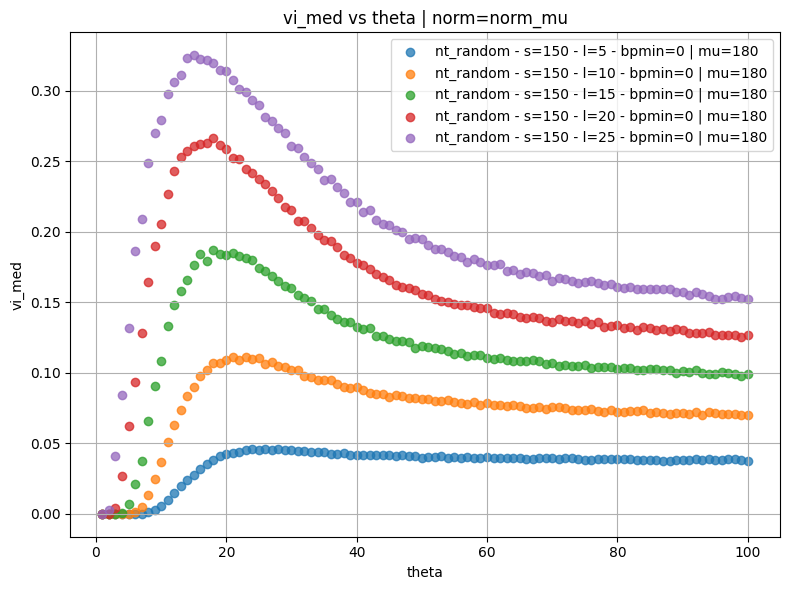

In [124]:
import matplotlib.pyplot as plt
import numpy as np

def plot_configs(
    df,
    scenarios,
    idxs,
    *,
    output="vi_med",
    fx_name="mu",
    norm_type="norm_mu",
    fx_value="s+l",          # "s+l" (par défaut) • scalaire • dict {idx: val} • callable(cfg)->val
    label_fn=None,           # par défaut: short_cfg_line(cfg)
    marker="o",
    alpha=0.75,
    ax=None,
):
    """
    Trace y(output) vs variable mobile pour plusieurs configs (scenarios[idxs]).
    - Fixe l'autre variable via fx_name/fx_value.
    - Réutilise ncl_cut_1D(df, cfg, output, fx_name, fx_val, norm_type).

    fx_value:
      - "s+l" (défaut) : utilise s+ l de la config
      - scalaire (int/float) : même valeur pour toutes les configs
      - dict {idx: val} : valeur par index de scenario
      - callable(cfg) -> val : fonction qui calcule la valeur à fixer
    """
    def _scalar(v):
        return v.item() if hasattr(v, "item") else v

    def _resolve_fx(cfg, i):
        if callable(fx_value):
            return fx_value(cfg)
        if isinstance(fx_value, dict):
            return fx_value[i]
        if isinstance(fx_value, (int, float)):
            return fx_value
        if fx_value == "s+l":
            return _scalar(cfg["s"]) + _scalar(cfg["l"])
        raise ValueError("fx_value doit être 's+l', un scalaire, un dict ou un callable(cfg).")

    mv_name = "mu" if fx_name == "theta" else "theta"
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    for i in idxs:
        cfg = scenarios[i]
        fx_val = _resolve_fx(cfg, i)
        x, y = ncl_cut_1D(df, cfg, output, fx_name, fx_val, norm_type=norm_type, plot_log2=False)
        if x.size == 0:
            continue
        lab = (label_fn(cfg) if label_fn else short_cfg_line(cfg)) + f" | {fx_name}={fx_val}"
        ax.scatter(x, y, marker=marker, alpha=alpha, label=lab)

    ax.set_title(f"{output} vs {mv_name} | norm={norm_type or 'raw'}")
    ax.set_xlabel(mv_name)
    ax.set_ylabel(output)
    ax.grid(True, which="both")
    ax.legend()
    plt.tight_layout()
    return ax


plot_configs(work_df, scenarios, [2,3,4,5,6],
             output="vi_med", fx_name="mu", norm_type="norm_mu", fx_value=180)
plt.show()

In [ ]:
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
from scipy.signal import find_peaks


plt.rcParams['font.size'] = 16


def sinusoid(t, A, omega, phi):
    return A * np.sin(omega * t + phi)

working_path = Path.home() / "Documents" / "PhD" / "Workspace" / "nucleo" / "outputs" / "ncl_test_0"
os.chdir(working_path)

df_work = pl.DataFrame()
df_work = pl.concat([pl.read_parquet(file) for file in working_path.rglob("*.parquet") if file.is_file()])
# print(df_work)

all_peaks = []


plt.figure(figsize=(8,6))
for row in df_work.iter_rows(named=True):

    # Extracting datas
    l = row["l"]
    s = row["s"]
    alphaf = row["alphaf"]
    alphao = row["alphao"]
    link_view = row["link_view"]
    label = f"l={row['l']}"
    norm = (s * alphao + alphaf * l) / (s + l)
    data = np.divide(link_view, norm)

    # Calculating sinusoid factors
    x = np.arange(0, len(data), 1)
    popt, _ = curve_fit(sinusoid, x, data)
    A_fit, omega_fit, phi_fit = popt

    # Getting the local maximas
    peaks, _ = find_peaks(data, distance=100)
    all_peaks.append(peaks)
    
    # Plotting
    plt.plot(data, label=f"{label} : y = {A_fit:.2f} sin({omega_fit:.2f} x + {phi_fit:.2f})")
    plt.scatter(peaks, data[peaks], color="red", marker="x")

    
plt.xlim([0, 3000])
plt.ylim([0, 10])
plt.xlabel("position in bp")
plt.ylabel("phase count")
plt.legend()
plt.show()


plt.figure(figsize=(8,6))
for i in range(0, len(all_peaks)):
    plt.plot(np.arange(0,10), all_peaks[i][0:10], label=f"{i}", marker="o")
plt.xlabel("peak count")
plt.ylabel("peak position")
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import polars as pl
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Définir le modèle sinusoidal
def sinusoid(t, A, omega, phi):
    return A * np.sin(omega * t + phi)

# Chargement des données
working_path = Path.home() / "Documents" / "PhD" / "Workspace" / "nucleo" / "outputs" / "ncl_test_0"
os.chdir(working_path)
df_work = pl.concat([pl.read_parquet(file) for file in working_path.rglob("*.parquet") if file.is_file()])

all_peaks = []

# Création de la figure principale
fig, ax = plt.subplots(figsize=(8,6))  # 🔧 Figure + Axes

for row in df_work.iter_rows(named=True):

    l = row["l"]
    s = row["s"]
    alphaf = row["alphaf"]
    alphao = row["alphao"]
    link_view = row["link_view"]
    label = f"l={l}"
    norm = (s * alphao + alphaf * l) / (s + l)
    data = np.divide(link_view, norm)

    x = np.arange(0, len(data), 1)
    popt, _ = curve_fit(sinusoid, x, data)
    A_fit, omega_fit, phi_fit = popt

    peaks, _ = find_peaks(data, distance=100)
    all_peaks.append(peaks)
    
    ax.plot(data, label=f"{label} : y = {A_fit:.2f} sin({omega_fit:.2f} x + {phi_fit:.2f})")
    # ax.scatter(peaks, data[peaks], color="red", marker="x")

# Légendes principales
ax.set_xlim([0, 3000])
ax.set_ylim([0, 10])
ax.set_xlabel("position in bp")
ax.set_ylabel("phase count")
ax.legend(loc="upper left", fontsize=8)

# 🔍 Inset plot : zoom sur un pic
ax_inset = inset_axes(ax, width="50%", height="50%", loc="upper right", borderpad=2)

# Exemple : zoomer sur la première courbe si elle existe
if len(all_peaks) > 0:
    for i in range(0, len(all_peaks)):
        ax_inset.plot(np.arange(0,10), all_peaks[i][0:10], label=f"{i}", marker="o")
        ax_inset.set_xlabel("peak count")
        ax_inset.set_ylabel("peak position")
        # ax_inset.set_xticks([])
        # ax_inset.set_yticks([])
        ax_inset.legend(fontsize=8)

# plt.tight_layout()
plt.show()


# .